# CIFAR-10 Image Classification

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install model_profiler

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## Importing the Libraries

In [4]:
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pylab import rcParams
import tensorflow as tf
# from tensorflow.image import resize
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNet
import keras
%matplotlib inline
from keras.datasets import cifar10
from keras.models import Sequential, load_model
from keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D, Reshape, Activation
# from keras.layers.normalization import BatchNormalization
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam, SGD
from keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from keras.utils import to_categorical
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import cv2
import albumentations as albu
from tensorflow.keras.applications.mobilenet import preprocess_input
from model_profiler import model_profiler
import os

## Loading the CIFAR-10 Dataset

In [5]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

170498071/170498071 [==============================] - 13s 0us/step


## Exploring the Images in the Dataset

In [ ]:
label_names = ["Airplane", "Automobile", "Bird", "Cat", "Deer", "Dog", "Frog", "Horse", "Ship", "Truck"]

Image number selected : 35299
Shape of image : (32, 32, 3)
Image class number: [3]
Image class name: Cat


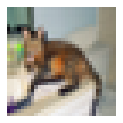

In [ ]:
#generating a random number to display a random image from the dataset along with the label's number and name

rcParams['figure.figsize'] = 2,2

imageId = np.random.randint(0, len(X_train))

plt.imshow(X_train[imageId])

plt.axis('off')

print("Image number selected : {}".format(imageId))
print("Shape of image : {}".format(X_train[imageId].shape))
print("Image class number: {}".format(y_train[imageId]))
print("Image class name: {}".format(label_names[y_train[imageId][0]]))

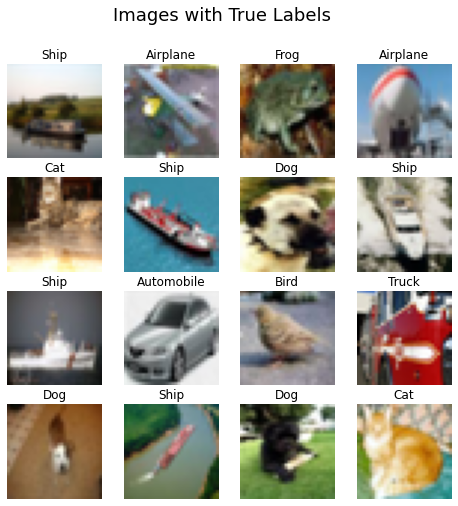

In [ ]:
#16 random images to display at a time along with their true labels
rcParams['figure.figsize'] = 8,8

num_row = 4
num_col = 4

#to get 4 * 4 = 16 images together
imageId = np.random.randint(0, len(X_train), num_row * num_col)

fig, axes = plt.subplots(num_row, num_col)
plt.suptitle('Images with True Labels', fontsize=18)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_train[imageId[k]])
        axes[i,j].set_title(label_names[y_train[imageId[k]][0]])
        axes[i,j].axis('off')

## Data Pre-processing

In [6]:
X_train.shape

(50000, 32, 32, 3)

In [7]:
X_test.shape

(10000, 32, 32, 3)

In [8]:
X_train = preprocess_input(X_train)
X_test = preprocess_input(X_test)

In [9]:
y_train.shape

(50000, 1)

In [10]:
y_test.shape

(10000, 1)

#### Converting class vectors to binary class matrices

In [11]:
y_train = to_categorical(y_train)
y_train.shape

(50000, 10)

In [12]:
y_test = to_categorical(y_test)
y_test.shape

(10000, 10)

#### Splitting the training dataset into training and validation datasets

In [13]:
# using stratified shuffle split to preserve the percentage of samples in each of the 10 classes
sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=123)

for train_index, val_index in sss.split(X_train, y_train):
    X_train_data, X_val_data = X_train[train_index], X_train[val_index]
    y_train_data, y_val_data = y_train[train_index], y_train[val_index]

print("Shape of training samples: ", X_train_data.shape)
print("Shape of validation samples: ", X_val_data.shape)

Shape of training samples:  (40000, 32, 32, 3)
Shape of validation samples:  (10000, 32, 32, 3)


#### Constants

In [14]:
#resizing the images as per EfficientNetB0 to size (224, 224)
height = 224
width = 224
n_channels = 3

n_classes = 10
input_shape = (height, width, n_channels)

epochs = 30
batch_size = 64

In [15]:
def resize_img(img, shape):
  return cv2.resize(img, (shape[1], shape[0]), interpolation=cv2.INTER_CUBIC)

In [16]:
# X_test = resize_img(X_test, (height, width))
X_test_data = np.empty((X_test.shape[0], height, width, n_channels))
for i, img in enumerate(X_test):
  # Resize as per new dimensions
  resized_img = resize_img(img, (height, width))
  # Store sample
  X_test_data[i] = resized_img

#### Custom Data Generator class 

In [ ]:
class DataGenerator(keras.utils.Sequence):
  def __init__(self, images, labels=None, mode='fit', batch_size=batch_size, dim=(height, width), n_channels=n_channels, n_classes=n_classes, shuffle=True, augment=False):
      # initializing the configuration of the generator
      self.images = images
      self.labels = labels
      self.mode = mode
      self.batch_size = batch_size
      self.dim = dim
      self.n_channels = n_channels
      self.n_classes = n_classes
      self.shuffle = shuffle
      self.augment = augment
      self.on_epoch_end()
  
  # method to be called after every epoch
  def on_epoch_end(self):
      self.indexes = np.arange(self.images.shape[0])
      if self.shuffle == True:
          np.random.shuffle(self.indexes)
  
  # return numbers of steps in an epoch using samples and batch size
  def __len__(self):
      return int(np.floor(len(self.images) / self.batch_size))
    
  # this method is called with the batch number as an argument to obtain a given batch of data
  def __getitem__(self, index):
    'Generate one batch of data'
    # Generate indexes of the batch
    indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

    if self.mode == 'fit':
      # Generate data
      X, y = self.__data_generation(indexes)
      # augmentation on the training dataset
      if self.augment == True:
        X = self.__augment_batch(X)
      return X, y
      # return X, keras.utils.to_categorical(y, num_classes=self.n_classes)
    elif self.mode == 'predict':
      # Generate data
      X = self.__data_generation(indexes)
      return X
    else:
      raise AttributeError("The mode should be set to either 'fit' or 'predict'.")

  def __data_generation(self, indexes):
    'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
    # Initialization
    X = np.empty((self.batch_size, *self.dim, self.n_channels))
    # y = np.empty((self.batch_size), dtype=int)

    # Generate data
    for i, ID in enumerate(indexes):
      # Generate pre-processed image
      img = self.images[ID]
      # Resize as per new dimensions
      img = resize_img(img, self.dim)
      # Store sample
      X[i] = img

    if self.mode == 'fit':
      y = self.labels[indexes]
      return X, y
    elif self.mode == 'predict':
      return X
            
  # augmentation for one image
  def __random_transform(self, img):
    composition = albu.Compose([albu.HorizontalFlip(p=0.5),
                                albu.VerticalFlip(p=0.5),
                                albu.GridDistortion(p=0.2),
                                albu.ElasticTransform(p=0.2)])
    return composition(image=img)['image']
  
  # augmentation for batch of images
  def __augment_batch(self, img_batch):
    for i in range(img_batch.shape[0]):
      img_batch[i] = self.__random_transform(img_batch[i])
    return img_batch

In [ ]:
training_generator = DataGenerator(X_train_data, y_train_data, augment=True)
validation_generator = DataGenerator(X_val_data, y_val_data, augment=False)

### Using pre-trained EfficientNetB0

In [20]:
# Initializing EfficientNetB0 as Base Model for Transfer Learning
mon = MobileNet(
  weights='imagenet',  # Load weights pre-trained on ImageNet.
  input_shape=input_shape,
  include_top=False, # Do not include the ImageNet classifier at the top.
  classes=n_classes
)  

x = mon.layers[-1].output
output = GlobalAveragePooling2D()(x)
output = Reshape((1, 1, 1024))(output)
output = Dropout(0.2)(output)
output = Conv2D(n_classes, (1, 1), padding='same')(output)
output = Reshape((n_classes,))(output)
output = Activation('softmax')(output)

model = Model(inputs=mon.input, outputs=output)

model.summary()

17225924/17225924 [==============================] - 2s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128    

In [17]:
# if resuming training 

optimizer = Adam(learning_rate=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='auto', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='auto', patience=5, factor= 0.5, min_lr= 1e-6, verbose=1)

# checkpoint
checkpoint_filepath="/content/drive/MyDrive/Dissertation/MobileNet_CIFAR10/my_model_32x32_64_5_preprocess.h5"
checkpoint = ModelCheckpoint(checkpoint_filepath, 
                             monitor='val_accuracy', 
                             verbose=1, 
                             save_best_only=True, 
                             save_weights_only=False,
                             mode='max')

In [ ]:
# if resuming training 
# model = load_model(checkpoint_filepath)

In [ ]:
model.load_weights('/content/drive/MyDrive/Dissertation/MobileNet_CIFAR10/weights.h5')

In [23]:
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [27]:
file = '/content/drive/MyDrive/Dissertation/MobileNet_CIFAR10/model.h5'
model.save(file)

In [28]:
os.path.getsize(file) / float(2 ** 20)

12.607170104980469

In [ ]:
model_history = model.fit(training_generator,
                          validation_data=validation_generator,
                          callbacks=[early_stop, rlrop, checkpoint],
                          verbose=1,
                          epochs=epochs)

with open('/content/drive/MyDrive/Dissertation/MobileNet_CIFAR10/trainHistoryDict1_30_32x32_64_5_preprocess', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

Epoch 1/30
625/625 [==============================] - ETA: 0s - loss: 0.8616 - accuracy: 0.7024
Epoch 1: val_accuracy improved from -inf to 0.83233, saving model to /content/drive/MyDrive/Dissertation/MobileNet_CIFAR10/my_model_32x32_64_5_preprocess.h5
625/625 [==============================] - 510s 797ms/step - loss: 0.8616 - accuracy: 0.7024 - val_loss: 0.4935 - val_accuracy: 0.8323 - lr: 1.0000e-04
Epoch 2/30
625/625 [==============================] - ETA: 0s - loss: 0.4872 - accuracy: 0.8326
Epoch 2: val_accuracy improved from 0.83233 to 0.88762, saving model to /content/drive/MyDrive/Dissertation/MobileNet_CIFAR10/my_model_32x32_64_5_preprocess.h5
625/625 [==============================] - 509s 814ms/step - loss: 0.4872 - accuracy: 0.8326 - val_loss: 0.3321 - val_accuracy: 0.8876 - lr: 1.0000e-04
Epoch 3/30
625/625 [==============================] - ETA: 0s - loss: 0.3794 - accuracy: 0.8672
Epoch 3: val_accuracy improved from 0.88762 to 0.90535, saving model to /content/drive/MyDr

In [ ]:
# if resuming training 
model_history = model.fit(training_generator,
                          validation_data=validation_generator,
                          callbacks=[early_stop, rlrop, checkpoint],
                          verbose=1,
                          epochs=epochs)

with open('/content/drive/MyDrive/Dissertation/MobileNet_CIFAR10/trainHistoryDict11_20', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

Epoch 1/5
625/625 [==============================] - ETA: 0s - loss: 0.0500 - accuracy: 0.9830
Epoch 1: val_accuracy did not improve from 0.95703
625/625 [==============================] - 527s 843ms/step - loss: 0.0500 - accuracy: 0.9830 - val_loss: 0.1750 - val_accuracy: 0.9562 - lr: 2.5000e-04
Epoch 2/5
625/625 [==============================] - ETA: 0s - loss: 0.0468 - accuracy: 0.9843
Epoch 2: val_accuracy did not improve from 0.95703
625/625 [==============================] - 526s 841ms/step - loss: 0.0468 - accuracy: 0.9843 - val_loss: 0.1674 - val_accuracy: 0.9564 - lr: 2.5000e-04
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 0.0447 - accuracy: 0.9841
Epoch 3: val_accuracy improved from 0.95703 to 0.95733, saving model to /content/drive/MyDrive/Dissertation/my_model.h5
625/625 [==============================] - 526s 840ms/step - loss: 0.0447 - accuracy: 0.9841 - val_loss: 0.1714 - val_accuracy: 0.9573 - lr: 2.5000e-04
Epoch 4/5
625/625 [==================

In [ ]:
# if resuming training 
model_history = model.fit(training_generator,
                          validation_data=validation_generator,
                          callbacks=[early_stop, rlrop, checkpoint],
                          verbose=1,
                          epochs=epochs)

with open('/content/drive/MyDrive/Dissertation/MobileNet_CIFAR10/trainHistoryDict21_30', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

Epoch 1/10
625/625 [==============================] - ETA: 0s - loss: 0.1673 - accuracy: 0.9425
Epoch 1: val_accuracy did not improve from 0.92107
625/625 [==============================] - 502s 804ms/step - loss: 0.1673 - accuracy: 0.9425 - val_loss: 0.2781 - val_accuracy: 0.9187 - lr: 0.0010
Epoch 2/10
625/625 [==============================] - ETA: 0s - loss: 0.1652 - accuracy: 0.9427
Epoch 2: val_accuracy did not improve from 0.92107
625/625 [==============================] - 503s 804ms/step - loss: 0.1652 - accuracy: 0.9427 - val_loss: 0.2824 - val_accuracy: 0.9142 - lr: 0.0010
Epoch 3/10
625/625 [==============================] - ETA: 0s - loss: 0.1600 - accuracy: 0.9452
Epoch 3: val_accuracy did not improve from 0.92107
625/625 [==============================] - 500s 799ms/step - loss: 0.1600 - accuracy: 0.9452 - val_loss: 0.3017 - val_accuracy: 0.9084 - lr: 0.0010
Epoch 4/10
625/625 [==============================] - ETA: 0s - loss: 0.1529 - accuracy: 0.9481
Epoch 4: val_accura

In [ ]:
# if resuming training 
model_history = model.fit(training_generator,
                          validation_data=validation_generator,
                          callbacks=[early_stop, rlrop, checkpoint],
                          verbose=1,
                          epochs=epochs)

with open('/content/drive/MyDrive/Dissertation/MobileNet_CIFAR10/trainHistoryDict31_40', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

Epoch 1/5
625/625 [==============================] - ETA: 0s - loss: 0.0381 - accuracy: 0.9869
Epoch 1: val_accuracy did not improve from 0.96144
625/625 [==============================] - 528s 843ms/step - loss: 0.0381 - accuracy: 0.9869 - val_loss: 0.1781 - val_accuracy: 0.9562 - lr: 2.5000e-04
Epoch 2/5
625/625 [==============================] - ETA: 0s - loss: 0.0385 - accuracy: 0.9872
Epoch 2: val_accuracy did not improve from 0.96144
625/625 [==============================] - 527s 843ms/step - loss: 0.0385 - accuracy: 0.9872 - val_loss: 0.1777 - val_accuracy: 0.9549 - lr: 2.5000e-04
Epoch 3/5
625/625 [==============================] - ETA: 0s - loss: 0.0376 - accuracy: 0.9879
Epoch 3: val_accuracy did not improve from 0.96144
625/625 [==============================] - 526s 841ms/step - loss: 0.0376 - accuracy: 0.9879 - val_loss: 0.1706 - val_accuracy: 0.9578 - lr: 2.5000e-04
Epoch 4/5
625/625 [==============================] - ETA: 0s - loss: 0.0389 - accuracy: 0.9873
Epoch 4: va

In [ ]:
#saving the trained model as data file in .h5 format
# model.save('EfficientNetb0_cifar10.h5')

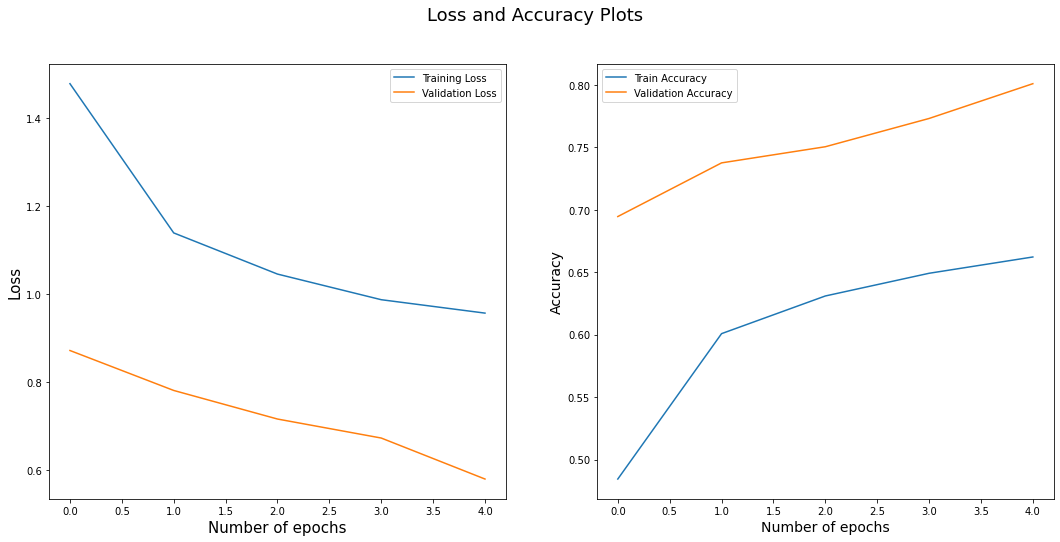

In [ ]:
#plot to visualize the loss and accuracy against number of epochs
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [ ]:
with open('/content/drive/MyDrive/Dissertation/trainHistoryDict1_20', "rb") as file_pi:
    history = pickle.load(file_pi)

FileNotFoundError: ignored

In [ ]:
history

{'loss': [0.5849419832229614,
  0.3700326383113861,
  0.3064170777797699,
  0.27293097972869873,
  0.246278315782547,
  0.23033766448497772,
  0.21354174613952637,
  0.20239146053791046,
  0.1890258938074112,
  0.18158122897148132,
  0.1659630835056305,
  0.10747212916612625,
  0.09192001819610596,
  0.0885956883430481,
  0.0823940560221672,
  0.08239929378032684,
  0.07752398401498795,
  0.06229483708739281,
  0.05111068859696388,
  0.05035535991191864],
 'accuracy': [0.7973750233650208,
  0.8745250105857849,
  0.8946250081062317,
  0.9050999879837036,
  0.9154999852180481,
  0.9202499985694885,
  0.9263749718666077,
  0.9299250245094299,
  0.9348250031471252,
  0.9383000135421753,
  0.9430500268936157,
  0.9637249708175659,
  0.9683499932289124,
  0.9685500264167786,
  0.9718499779701233,
  0.9720749855041504,
  0.9730499982833862,
  0.9789999723434448,
  0.9828000068664551,
  0.9836000204086304],
 'val_loss': [0.3409382402896881,
  0.3738127052783966,
  0.27595892548561096,
  0.2895

## Model Evaluation

In [18]:
model = load_model(checkpoint_filepath)

In [19]:
model.save_weights('/content/drive/MyDrive/Dissertation/MobileNet_CIFAR10/weights.h5')

In [ ]:
test_loss, test_accuracy = model.evaluate(X_test_data, y_test, verbose=1)

print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

313/313 [==============================] - 18s 36ms/step - loss: 0.1802 - accuracy: 0.9466
Test Accuracy:  94.66 %


In [ ]:
# Initializing EfficientNetB0 as Base Model for Transfer Learning
mon = MobileNet(
  weights='imagenet',  # Load weights pre-trained on ImageNet.
  input_shape=input_shape,
  include_top=False, # Do not include the ImageNet classifier at the top.
  classes=n_classes
)  

x = mon.layers[-1].output
output = GlobalAveragePooling2D()(x)
output = Reshape((1, 1, 1024))(output)
output = Dropout(0.2)(output)
output = Conv2D(n_classes, (1, 1), padding='same')(output)
output = Reshape((n_classes,))(output)
output = Activation('softmax')(output)

model = Model(inputs=mon.input, outputs=output)

model.summary()

17225924/17225924 [==============================] - 1s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                                 
 conv_dw_1_bn (BatchNormaliz  (None, 112, 112, 32)     128    

In [ ]:
use_units = ['GPU IDs', 'MFLOPs', 'GB', 'Million', 'MB']
profile = model_profiler(model, batch_size, use_units=use_units)
print(profile)

IndexError: ignored

## Model Prediction

In [ ]:
# y_pred = model.predict(DataGenerator(X_test, mode='predict', augment=False, shuffle=False), verbose=1)
# y_pred = np.argmax(y_pred, axis=1)
# test_accuracy = accuracy_score(np.argmax(y_test, axis=1), y_pred)

# print('Test Accuracy: ', round((test_accuracy * 100), 2), "%")

 20/156 [==>...........................] - ETA: 14s

KeyboardInterrupt: ignored

## Confusion Matrix

In [ ]:
cm = confusion_matrix(np.argmax(y_test, axis=1), y_pred)
print(cm)

[[93  0  0 ...  0  0  0]
 [ 0 92  0 ...  0  0  0]
 [ 0  0 81 ...  0  0  0]
 ...
 [ 0  0  0 ... 88  0  0]
 [ 0  0  3 ...  0 66  0]
 [ 0  0  0 ...  0  1 84]]


In [ ]:
#report to see which category has been predicted incorectly and which has been predicted correctly
target = ["Category {}".format(i) for i in range(n_classes)]
print(classification_report(np.argmax(y_test, axis=1), y_pred, target_names=target))

              precision    recall  f1-score   support

  Category 0       0.89      0.93      0.91       100
  Category 1       0.88      0.92      0.90       100
  Category 2       0.60      0.81      0.69       100
  Category 3       0.75      0.82      0.78       100
  Category 4       0.72      0.71      0.71       100
  Category 5       0.80      0.78      0.79       100
  Category 6       0.87      0.90      0.88       100
  Category 7       0.92      0.78      0.84       100
  Category 8       0.91      0.96      0.94       100
  Category 9       0.89      0.92      0.91       100
 Category 10       0.71      0.55      0.62       100
 Category 11       0.52      0.39      0.45       100
 Category 12       0.85      0.80      0.82       100
 Category 13       0.83      0.80      0.82       100
 Category 14       0.95      0.82      0.88       100
 Category 15       0.83      0.92      0.87       100
 Category 16       0.83      0.83      0.83       100
 Category 17       0.90    

## Visualizing the Predictions

In [ ]:
#dataframe of predictions
prediction = pd.DataFrame(y_pred)
prediction.head()

,0
0,68
1,33
2,55
3,51
4,71


True Label: Whale
Predicted Label: Whale


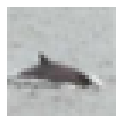

In [ ]:
#generating a random number to display a random image from the dataset along with the true and predicted label
imageId = np.random.randint(0, len(X_test))

rcParams['figure.figsize'] = 2,2

plt.imshow(X_test[imageId])

plt.axis('off')

print("True Label: " + str(subCategory.iloc[testData['fine_labels'][imageId]][0].capitalize()))
print("Predicted Label: " + str(subCategory.iloc[prediction.iloc[imageId]]).split()[2].capitalize())

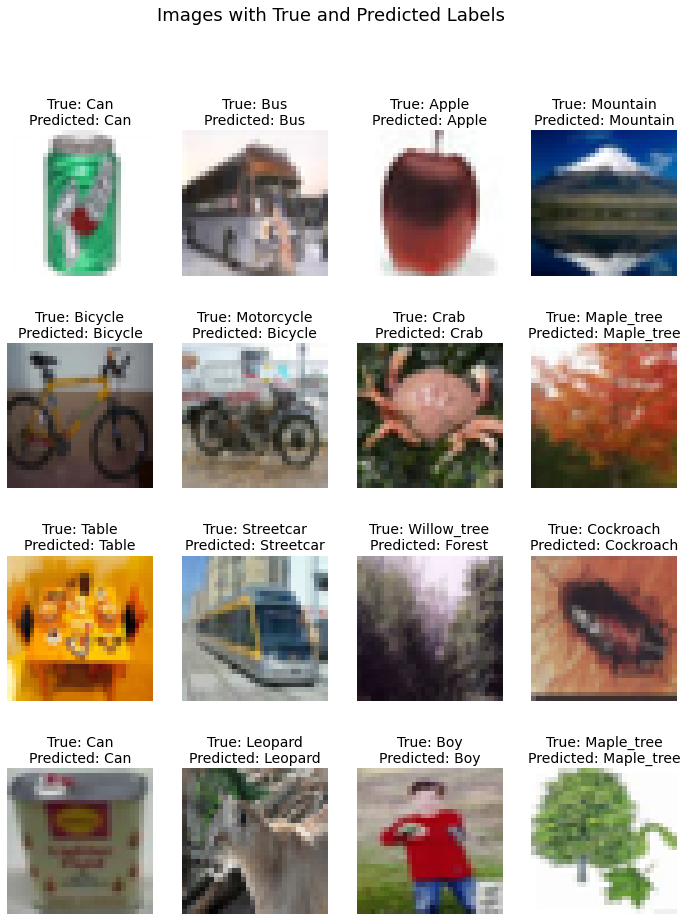

In [ ]:
#16 random images to display at a time along with their true and random labels
rcParams['figure.figsize'] = 12,15

num_row = 4
num_col = 4

imageId = np.random.randint(0, len(X_test), num_row * num_col)

fig, axes = plt.subplots(num_row, num_col)

for i in range(0, num_row):
    for j in range(0, num_col):
        k = (i*num_col)+j
        axes[i,j].imshow(X_test[imageId[k]])
        axes[i,j].set_title("True: " + str(subCategory.iloc[testData['fine_labels'][imageId[k]]][0]).capitalize() 
                             + "\nPredicted: " + str(subCategory.iloc[prediction.iloc[imageId[k]]]).split()[2].capitalize(), 
                            fontsize=14)
        axes[i,j].axis('off')
        fig.suptitle("Images with True and Predicted Labels", fontsize=18) 

plt.show()

## Testing the model

In [ ]:
#function to resize the image
def resize_test_image(test_img):

    img = cv2.imread(test_img)
    #plt.imshow(img)
    img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    #plt.imshow(img_RGB)
    resized_img = cv2.resize(img_RGB, (224, 224))
    #plt.imshow(resized_img)
    resized_img = resized_img / 255.
    #plt.imshow(resized_img)
    return resized_img
    
#resize_test_image('orange.jpeg')

In [ ]:
#function to get prediction for test image from the model
def predict_test_image(test_img):
    
    resized_img = resize_test_image(test_img)
    prediction = model.predict(np.array([resized_img]))
    
    return prediction

#predict_test_image('orange.jpeg')

In [ ]:
#function to get the sorted prediction
def sort_prediction_test_image(test_img):
    
    prediction = predict_test_image(test_img)
    
    index = np.arange(0,100)
    
    for i in range(100):
        for j in range(100):
            if prediction[0][index[i]] > prediction[0][index[j]]:
                temp = index[i]
                index[i] = index[j]
                index[j] = temp
                
    return index

#sort_prediction_test_image('orange.jpeg')

In [ ]:
#function to get the dataframe for top 5 predictions
def df_top5_prediction_test_image(test_img):
    
    sorted_index = sort_prediction_test_image(test_img)
    prediction = predict_test_image(test_img)
    
    subCategory_name = []
    prediction_score = []
    
    k = sorted_index[:6] 
    
    for i in range(len(k)):
        subCategory_name.append(subCategory.iloc[k[i]][0])
        prediction_score.append(round(prediction[0][k[i]], 2))
        
    df = pd.DataFrame(list(zip(subCategory_name, prediction_score)), columns=['Label', 'Probability'])  
    
    return df

#df_top5_prediction_test_image('orange.jpeg')

In [ ]:
#function to get the plot for top 5 predictions 
def plot_top5_prediction_test_image(test_img):
    
    fig, axes = plt.subplots(1, 2, figsize=(15,4))
    fig.suptitle("Prediction", fontsize=18)
    
    new_img = plt.imread(test_img)
    axes[0].imshow(new_img)
    axes[0].axis('off')
    
    data = df_top5_prediction_test_image(test_img)
    x=df_top5_prediction_test_image(test_img)['Label']
    y=df_top5_prediction_test_image(test_img)['Probability']
    
    axes[1] = sns.barplot(x=x, y=y, data=data, color="green")
    
    plt.xlabel('Label', fontsize=14)
    plt.ylabel('Probability', fontsize=14)
    
    plt.ylim(0,1.0)
    
    axes[1].grid(False)
    axes[1].spines["top"].set_visible(False)
    axes[1].spines["right"].set_visible(False)
    axes[1].spines["bottom"].set_visible(False)
    axes[1].spines["left"].set_visible(False)
    
    plt.show()

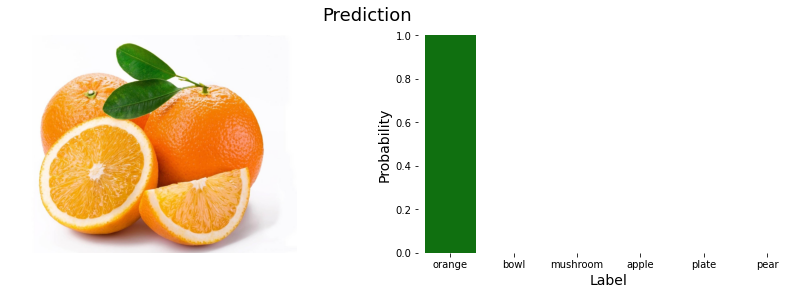

In [ ]:
plot_top5_prediction_test_image('orange.jpeg')

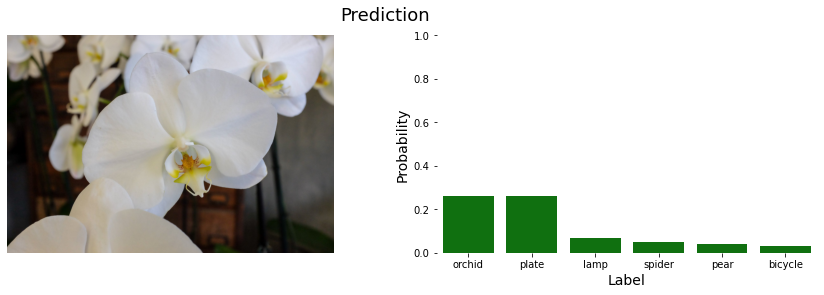

In [ ]:
plot_top5_prediction_test_image('Orchid.jpg')

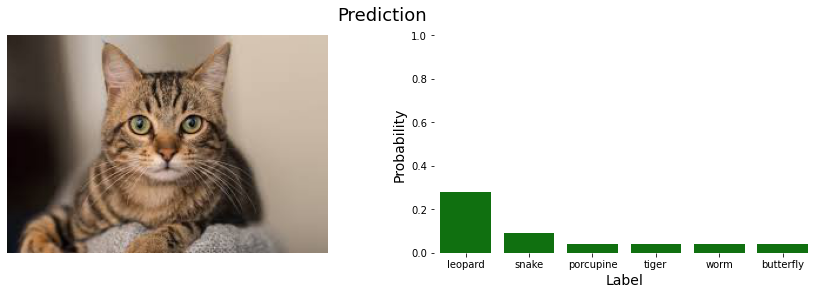

In [ ]:
plot_top5_prediction_test_image('cat.jpeg')

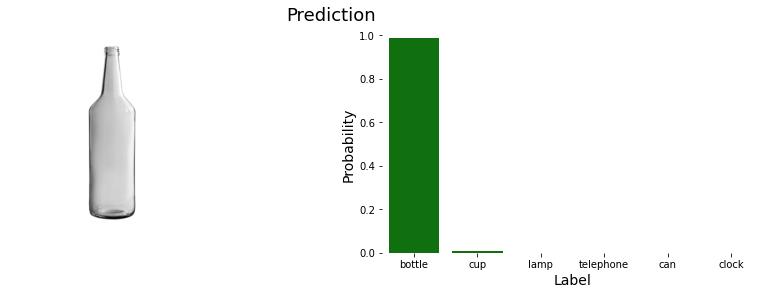

In [ ]:
plot_top5_prediction_test_image('bottle.jpeg')

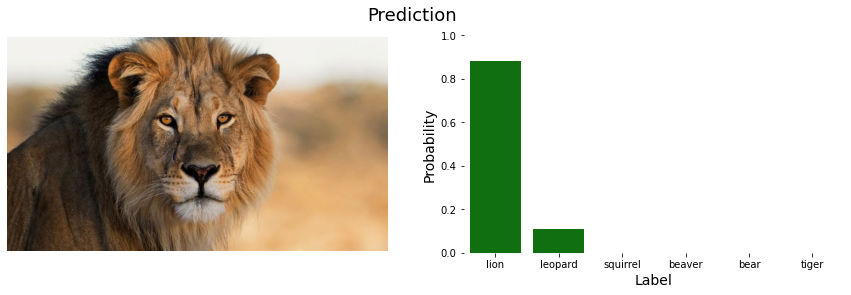

In [ ]:
plot_top5_prediction_test_image('lion.jpg')

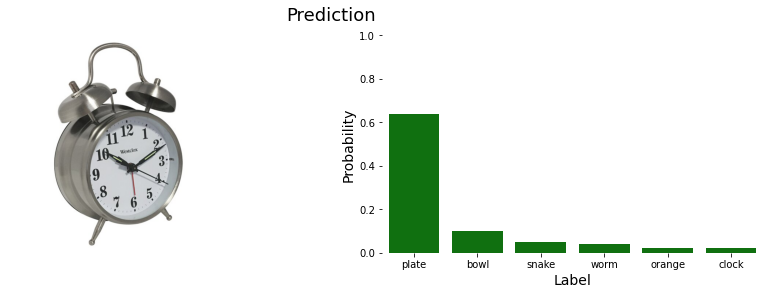

In [ ]:
plot_top5_prediction_test_image('clock.jpg')

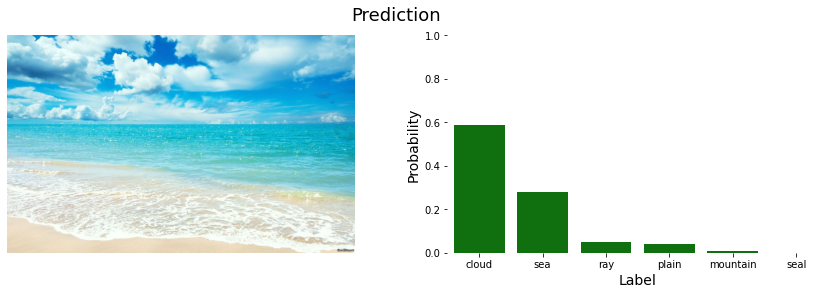

In [ ]:
plot_top5_prediction_test_image('sea.jpg')

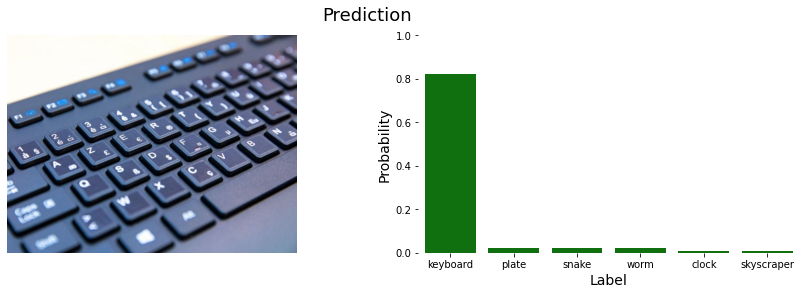

In [ ]:
plot_top5_prediction_test_image('keyboard.jpeg')

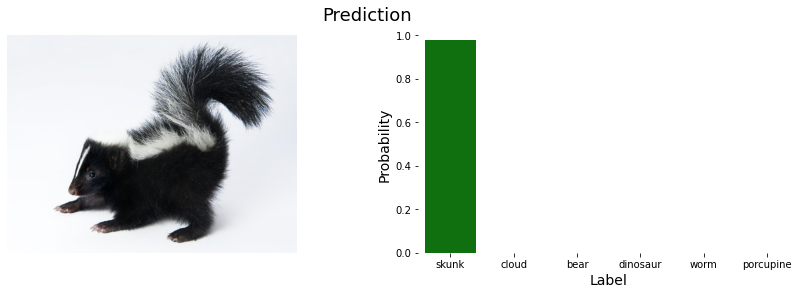

In [ ]:
plot_top5_prediction_test_image('skunk.jpg')

In [ ]:
#saving the trained model as data file in .h5 format
model.save('cifar_efficientnetb0_model.h5')